## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./saved_models/diffusion_model_finetuned.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [42]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth (m)", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    yticks_ix = np.array(ax[0].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[0].set_yticklabels(depth_label, rotation=0)
    ax[0].collections[0].colorbar.set_label("Actual Temperature ($^\circ$C)")

    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)")
    yticks_ix = np.array(ax[1].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[1].set_yticklabels(depth_label, rotation=0)
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    yticks_ix = np.array(ax[2].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[2].set_yticklabels(depth_label, rotation=0)
    ax[2].collections[0].colorbar.set_label("Absolute Error ($^\circ$C)")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")



RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 2.7878406
RMSE of after m4 2.4540486
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 3.41734
RMSE of after m4 3.3486347
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 4.882973
RMSE of after m4 4.7756357
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 5.0396314
RMSE of after m4 4.901795
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 5.017928
RMSE of after m4 4.8670034
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 4.912722
RMSE of after m4 4.7625556
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 4.900732
RMSE of after m4 4.7214446
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 4.902558
RMSE of after m4 4.7160206
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 4.9521375
RMSE of after m4 4.766916
RMSE 

RMSE of after m1 0.0137356585
RMSE of after m3 5.871786
RMSE of after m4 4.3493176
RMSE of after m0 0.008596247
RMSE of after m1 0.014596719
RMSE of after m3 6.0350504
RMSE of after m4 4.428234
RMSE of after m0 0.0072846273
RMSE of after m1 0.012779305
RMSE of after m3 6.0938077
RMSE of after m4 4.383391
RMSE of after m0 0.008523658
RMSE of after m1 0.012053964
RMSE of after m3 5.925434
RMSE of after m4 4.221562
RMSE of after m0 0.0086771995
RMSE of after m1 0.012808083
RMSE of after m3 5.881216
RMSE of after m4 4.175628
RMSE of after m0 0.00904542
RMSE of after m1 0.013971576
RMSE of after m3 5.9168153
RMSE of after m4 4.1851144
RMSE of after m0 0.008355987
RMSE of after m1 0.013402943
RMSE of after m3 5.7603416
RMSE of after m4 4.122929
RMSE of after m0 0.0081180995
RMSE of after m1 0.013234384
RMSE of after m3 5.0544295
RMSE of after m4 3.7915578
RMSE of after m0 0.0074203685
RMSE of after m1 0.011381421
RMSE of after m3 4.746318
RMSE of after m4 3.6350517
RMSE of after m0 0.0124031

RMSE of after m1 0.01966602
RMSE of after m3 3.273716
RMSE of after m4 3.6773274
RMSE of after m0 0.0087290825
RMSE of after m1 0.012664626
RMSE of after m3 3.343612
RMSE of after m4 3.766015
RMSE of after m0 0.008423593
RMSE of after m1 0.011023106
RMSE of after m3 3.4768648
RMSE of after m4 3.901533
RMSE of after m0 0.008955818
RMSE of after m1 0.0125395
RMSE of after m3 3.5471044
RMSE of after m4 3.9955938
RMSE of after m0 0.009285526
RMSE of after m1 0.013135058
RMSE of after m3 3.665566
RMSE of after m4 4.1479187
RMSE of after m0 0.008633956
RMSE of after m1 0.013235392
RMSE of after m3 3.7648726
RMSE of after m4 4.271064
RMSE of after m0 0.008147257
RMSE of after m1 0.014740954
RMSE of after m3 3.8969991
RMSE of after m4 4.475164
RMSE of after m0 0.008542743
RMSE of after m1 0.014813299
RMSE of after m3 3.9342272
RMSE of after m4 4.5166078
RMSE of after m0 0.007629712
RMSE of after m1 0.013141662
RMSE of after m3 3.9299862
RMSE of after m4 4.51057
RMSE of after m0 0.00899696
RMSE

RMSE of after m1 0.016258543
RMSE of after m3 5.033565
RMSE of after m4 6.3141418
RMSE of after m0 0.008773983
RMSE of after m1 0.015119097
RMSE of after m3 4.9849834
RMSE of after m4 6.201477
RMSE of after m0 0.0101601975
RMSE of after m1 0.01642088
RMSE of after m3 4.958028
RMSE of after m4 6.1967998
RMSE of after m0 0.011752434
RMSE of after m1 0.018694546
RMSE of after m3 4.827175
RMSE of after m4 6.0726624
RMSE of after m0 0.01156481
RMSE of after m1 0.019486062
RMSE of after m3 4.8028865
RMSE of after m4 6.079267
RMSE of after m0 0.009790882
RMSE of after m1 0.018661054
RMSE of after m3 4.8063116
RMSE of after m4 6.140667
RMSE of after m0 0.0082443105
RMSE of after m1 0.0145359095
RMSE of after m3 4.936183
RMSE of after m4 6.280308
RMSE of after m0 0.008855764
RMSE of after m1 0.013906356
RMSE of after m3 4.9475865
RMSE of after m4 6.21748
RMSE of after m0 0.010016842
RMSE of after m1 0.01565856
RMSE of after m3 4.8909225
RMSE of after m4 6.1677184
RMSE of after m0 0.010662739
RM

RMSE of after m3 6.8476505
RMSE of after m4 6.5939426
RMSE of after m0 0.010950277
RMSE of after m1 0.015192482
RMSE of after m3 6.4682384
RMSE of after m4 6.2605844
RMSE of after m0 0.011870217
RMSE of after m1 0.013116003
RMSE of after m3 5.8916254
RMSE of after m4 5.8230476
RMSE of after m0 0.010040741
RMSE of after m1 0.0072762994
RMSE of after m3 6.657231
RMSE of after m4 6.555357
RMSE of after m0 0.011507431
RMSE of after m1 0.008306458
RMSE of after m3 7.362726
RMSE of after m4 6.9530187
RMSE of after m0 0.011755713
RMSE of after m1 0.012300753
RMSE of after m3 7.960278
RMSE of after m4 7.2913594
RMSE of after m0 0.01231891
RMSE of after m1 0.013831374
RMSE of after m3 8.668224
RMSE of after m4 7.622785
RMSE of after m0 0.010981633
RMSE of after m1 0.037430696
RMSE of after m3 8.030351
RMSE of after m4 6.981407
RMSE of after m0 0.013034693
RMSE of after m1 0.021835888
RMSE of after m3 8.064763
RMSE of after m4 6.7664857
RMSE of after m0 0.016087119
RMSE of after m1 0.022346275
R

RMSE of after m1 0.02096818
RMSE of after m3 1.5068585
RMSE of after m4 1.4506547
RMSE of after m0 0.020618929
RMSE of after m1 0.020902019
RMSE of after m3 1.4468038
RMSE of after m4 1.3938233
RMSE of after m0 0.019240603
RMSE of after m1 0.020079765
RMSE of after m3 1.4438018
RMSE of after m4 1.392536
RMSE of after m0 0.019193206
RMSE of after m1 0.020598898
RMSE of after m3 1.4808226
RMSE of after m4 1.4162885
RMSE of after m0 0.020178972
RMSE of after m1 0.020909553
RMSE of after m3 1.3526336
RMSE of after m4 1.2973869
RMSE of after m0 0.017972974
RMSE of after m1 0.018674243
RMSE of after m3 1.3740753
RMSE of after m4 1.3194778
RMSE of after m0 0.01566206
RMSE of after m1 0.019016918
RMSE of after m3 1.5140448
RMSE of after m4 1.4526527
RMSE of after m0 0.01902777
RMSE of after m1 0.01956741
RMSE of after m3 1.5312685
RMSE of after m4 1.4710581
RMSE of after m0 0.021812191
RMSE of after m1 0.020064667
RMSE of after m3 1.5388649
RMSE of after m4 1.4753294
RMSE of after m0 0.0232028

RMSE of after m1 0.026643809
RMSE of after m3 1.6164345
RMSE of after m4 1.3443311
RMSE of after m0 0.026895829
RMSE of after m1 0.025710002
RMSE of after m3 1.9945318
RMSE of after m4 1.6056333
RMSE of after m0 0.02939299
RMSE of after m1 0.027740333
RMSE of after m3 2.0868971
RMSE of after m4 1.67835
RMSE of after m0 0.031585027
RMSE of after m1 0.027921442
RMSE of after m3 2.0566056
RMSE of after m4 1.6435599
RMSE of after m0 0.030288914
RMSE of after m1 0.028121538
RMSE of after m3 2.0582197
RMSE of after m4 1.6412597
RMSE of after m0 0.029451052
RMSE of after m1 0.026197037
RMSE of after m3 2.0282245
RMSE of after m4 1.6169894
RMSE of after m0 0.02796794
RMSE of after m1 0.026941504
RMSE of after m3 1.9628892
RMSE of after m4 1.5664643
RMSE of after m0 0.026549391
RMSE of after m1 0.026526941
RMSE of after m3 1.9383494
RMSE of after m4 1.5440737
RMSE of after m0 0.025477381
RMSE of after m1 0.022872934
RMSE of after m3 2.1603017
RMSE of after m4 1.7265295
RMSE of after m0 0.026628

RMSE of after m4 3.8279786
RMSE of after m0 0.009362352
RMSE of after m1 0.01600249
RMSE of after m3 3.405623
RMSE of after m4 3.6500304
RMSE of after m0 0.00857767
RMSE of after m1 0.015379159
RMSE of after m3 3.1425123
RMSE of after m4 3.3627653
RMSE of after m0 0.008703747
RMSE of after m1 0.015875753
RMSE of after m3 3.0709698
RMSE of after m4 3.3261392
RMSE of after m0 0.008618224
RMSE of after m1 0.014808938
RMSE of after m3 3.0329328
RMSE of after m4 3.3210151
RMSE of after m0 0.007812612
RMSE of after m1 0.012398266
RMSE of after m3 3.1489177
RMSE of after m4 3.4988148
RMSE of after m0 0.007875279
RMSE of after m1 0.010538659
RMSE of after m3 3.251476
RMSE of after m4 3.5655382
RMSE of after m0 0.008983547
RMSE of after m1 0.01124075
RMSE of after m3 3.3161426
RMSE of after m4 3.6453662
RMSE of after m0 0.009062707
RMSE of after m1 0.012226181
RMSE of after m3 3.4584794
RMSE of after m4 3.8112836
RMSE of after m0 0.009342379
RMSE of after m1 0.01364898
RMSE of after m3 3.542257

RMSE of after m0 0.010929921
RMSE of after m1 0.017819678
RMSE of after m3 5.070858
RMSE of after m4 6.260294
RMSE of after m0 0.008751854
RMSE of after m1 0.016254261
RMSE of after m3 5.0330534
RMSE of after m4 6.2746816
RMSE of after m0 0.008736889
RMSE of after m1 0.014330193
RMSE of after m3 5.1113195
RMSE of after m4 6.2470527
RMSE of after m0 0.009027241
RMSE of after m1 0.013099123
RMSE of after m3 5.0976963
RMSE of after m4 6.2685213
RMSE of after m0 0.009704613
RMSE of after m1 0.014365976
RMSE of after m3 5.1830525
RMSE of after m4 6.3835397
RMSE of after m0 0.010407115
RMSE of after m1 0.016490452
RMSE of after m3 5.121374
RMSE of after m4 6.3496814
RMSE of after m0 0.011062472
RMSE of after m1 0.018736122
RMSE of after m3 5.0394316
RMSE of after m4 6.290981
RMSE of after m0 0.011433368
RMSE of after m1 0.019974763
RMSE of after m3 4.849108
RMSE of after m4 6.075786
RMSE of after m0 0.007036466
RMSE of after m1 0.014739249
RMSE of after m3 4.81725
RMSE of after m4 5.9050775


RMSE of after m1 0.01583187
RMSE of after m3 5.1908255
RMSE of after m4 5.9860096
RMSE of after m0 0.012091352
RMSE of after m1 0.0198009
RMSE of after m3 4.971049
RMSE of after m4 5.772727
RMSE of after m0 0.011370251
RMSE of after m1 0.019660609
RMSE of after m3 4.839867
RMSE of after m4 5.638569
RMSE of after m0 0.010361853
RMSE of after m1 0.019357374
RMSE of after m3 4.71614
RMSE of after m4 5.5185666
RMSE of after m0 0.0073630824
RMSE of after m1 0.010294827
RMSE of after m3 4.8478913
RMSE of after m4 5.546577
RMSE of after m0 0.008146623
RMSE of after m1 0.011342621
RMSE of after m3 5.3416805
RMSE of after m4 6.064887
RMSE of after m0 0.008453544
RMSE of after m1 0.012314353
RMSE of after m3 5.4838734
RMSE of after m4 6.159293
RMSE of after m0 0.009124459
RMSE of after m1 0.013982297
RMSE of after m3 5.445229
RMSE of after m4 6.1463685
RMSE of after m0 0.0079936
RMSE of after m1 0.0134815
RMSE of after m3 5.412884
RMSE of after m4 6.121529
RMSE of after m0 0.007854843
RMSE of af

RMSE of after m3 4.341832
RMSE of after m4 3.6181867
RMSE of after m0 0.026351959
RMSE of after m1 0.021061873
RMSE of after m3 4.504314
RMSE of after m4 3.7285523
RMSE of after m0 0.023319222
RMSE of after m1 0.020668078
RMSE of after m3 4.7064767
RMSE of after m4 3.859528
RMSE of after m0 0.020958899
RMSE of after m1 0.02039223
RMSE of after m3 4.780984
RMSE of after m4 3.912192
RMSE of after m0 0.02144151
RMSE of after m1 0.019990666
RMSE of after m3 4.6583753
RMSE of after m4 3.814374
RMSE of after m0 0.025842559
RMSE of after m1 0.021878526
RMSE of after m3 4.632022
RMSE of after m4 3.7910907
RMSE of after m0 0.024010092
RMSE of after m1 0.019990845
RMSE of after m3 4.902936
RMSE of after m4 3.9357793
RMSE of after m0 0.023470923
RMSE of after m1 0.02076637
RMSE of after m3 4.5393033
RMSE of after m4 3.703657
RMSE of after m0 0.022141192
RMSE of after m1 0.02209468
RMSE of after m3 4.267753
RMSE of after m4 3.531789
RMSE of after m0 0.022363497
RMSE of after m1 0.021890087
RMSE of

RMSE of after m1 0.025178945
RMSE of after m3 1.2338781
RMSE of after m4 1.0775245
RMSE of after m0 0.029855106
RMSE of after m1 0.022898035
RMSE of after m3 1.2223659
RMSE of after m4 1.0647843
RMSE of after m0 0.0277603
RMSE of after m1 0.021956677
RMSE of after m3 1.1884934
RMSE of after m4 1.030653
RMSE of after m0 0.029669084
RMSE of after m1 0.022765158
RMSE of after m3 1.1629211
RMSE of after m4 1.004485
RMSE of after m0 0.029876357
RMSE of after m1 0.023493519
RMSE of after m3 1.1547945
RMSE of after m4 0.9994801
RMSE of after m0 0.028178101
RMSE of after m1 0.023879189
RMSE of after m3 1.1591022
RMSE of after m4 1.0066015
RMSE of after m0 0.028083164
RMSE of after m1 0.023683403
RMSE of after m3 1.1383151
RMSE of after m4 0.98685294
RMSE of after m0 0.028324584
RMSE of after m1 0.021538213
RMSE of after m3 1.0695866
RMSE of after m4 0.91867065
RMSE of after m0 0.02777677
RMSE of after m1 0.02405611
RMSE of after m3 0.99327606
RMSE of after m4 0.84734917
RMSE of after m0 0.0265

RMSE of after m1 0.024358068
RMSE of after m3 3.6903043
RMSE of after m4 2.6336927
RMSE of after m0 0.019275643
RMSE of after m1 0.024691088
RMSE of after m3 4.232013
RMSE of after m4 2.940595
RMSE of after m0 0.019147579
RMSE of after m1 0.027450593
RMSE of after m3 3.8331802
RMSE of after m4 2.7357497
RMSE of after m0 0.020157
RMSE of after m1 0.031716477
RMSE of after m3 3.7972283
RMSE of after m4 2.676191
RMSE of after m0 0.020138217
RMSE of after m1 0.029478375
RMSE of after m3 4.0406785
RMSE of after m4 2.8147683
RMSE of after m0 0.019770734
RMSE of after m1 0.02268882
RMSE of after m3 4.029151
RMSE of after m4 2.8178737
RMSE of after m0 0.017721679
RMSE of after m1 0.024150405
RMSE of after m3 3.9918187
RMSE of after m4 2.7886343
RMSE of after m0 0.017307326
RMSE of after m1 0.024085354
RMSE of after m3 4.3662486
RMSE of after m4 3.006227
RMSE of after m0 0.019168513
RMSE of after m1 0.027500441
RMSE of after m3 4.698601
RMSE of after m4 3.2010486
RMSE of after m0 0.018942788
RM

RMSE of after m1 0.016867286
RMSE of after m3 4.4070377
RMSE of after m4 5.1731052
RMSE of after m0 0.010069848
RMSE of after m1 0.018214898
RMSE of after m3 4.374321
RMSE of after m4 5.106478
RMSE of after m0 0.008990706
RMSE of after m1 0.016525552
RMSE of after m3 4.4039235
RMSE of after m4 5.1078753
RMSE of after m0 0.009963966
RMSE of after m1 0.015233397
RMSE of after m3 4.358532
RMSE of after m4 5.0435777
RMSE of after m0 0.009813113
RMSE of after m1 0.017308367
RMSE of after m3 4.0732183
RMSE of after m4 4.7782855
RMSE of after m0 0.01017708
RMSE of after m1 0.017487193
RMSE of after m3 4.0679555
RMSE of after m4 4.8143573
RMSE of after m0 0.009161686
RMSE of after m1 0.017634176
RMSE of after m3 4.0714316
RMSE of after m4 4.83401
RMSE of after m0 0.0074823466
RMSE of after m1 0.01451399
RMSE of after m3 4.117994
RMSE of after m4 4.863225
RMSE of after m0 0.008474256
RMSE of after m1 0.014898245
RMSE of after m3 4.188221
RMSE of after m4 4.91632
RMSE of after m0 0.008957391
RMS

RMSE of after m4 6.331097
RMSE of after m0 0.010477304
RMSE of after m1 0.019628968
RMSE of after m3 5.0292363
RMSE of after m4 6.200003
RMSE of after m0 0.011839538
RMSE of after m1 0.021016322
RMSE of after m3 4.98535
RMSE of after m4 6.175225
RMSE of after m0 0.012103662
RMSE of after m1 0.021633206
RMSE of after m3 4.9495745
RMSE of after m4 6.1594896
RMSE of after m0 0.012531288
RMSE of after m1 0.022627834
RMSE of after m3 4.9910903
RMSE of after m4 6.262077
RMSE of after m0 0.012242397
RMSE of after m1 0.023300974
RMSE of after m3 4.949971
RMSE of after m4 6.238242
RMSE of after m0 0.008765867
RMSE of after m1 0.018996824
RMSE of after m3 4.8281727
RMSE of after m4 6.0085764
RMSE of after m0 0.009773105
RMSE of after m1 0.016417198
RMSE of after m3 4.8481517
RMSE of after m4 5.95545
RMSE of after m0 0.010929835
RMSE of after m1 0.017766224
RMSE of after m3 4.799688
RMSE of after m4 5.913631
RMSE of after m0 0.010966181
RMSE of after m1 0.019089222
RMSE of after m3 4.8902397
RMSE

RMSE of after m0 0.006021027
RMSE of after m1 0.008373492
RMSE of after m3 6.550389
RMSE of after m4 6.4360876
RMSE of after m0 0.0059226532
RMSE of after m1 0.0069429073
RMSE of after m3 6.004925
RMSE of after m4 5.965814
RMSE of after m0 0.0077735167
RMSE of after m1 0.006294758
RMSE of after m3 6.2553153
RMSE of after m4 6.170601
RMSE of after m0 0.0067130383
RMSE of after m1 0.0074504553
RMSE of after m3 6.2567024
RMSE of after m4 6.1428695
RMSE of after m0 0.007944913
RMSE of after m1 0.009741938
RMSE of after m3 5.7007947
RMSE of after m4 5.733665
RMSE of after m0 0.0064980783
RMSE of after m1 0.006445838
RMSE of after m3 5.8482227
RMSE of after m4 5.8527355
RMSE of after m0 0.006588568
RMSE of after m1 0.0050530764
RMSE of after m3 6.393254
RMSE of after m4 6.2486763
RMSE of after m0 0.007350377
RMSE of after m1 0.005479071
RMSE of after m3 6.5855765
RMSE of after m4 6.3078713
RMSE of after m0 0.012653585
RMSE of after m1 0.013170179
RMSE of after m3 8.18246
RMSE of after m4 7.2

RMSE of after m4 2.7450879
RMSE of after m0 0.020632608
RMSE of after m1 0.020896085
RMSE of after m3 3.1285698
RMSE of after m4 2.7373822
RMSE of after m0 0.022725012
RMSE of after m1 0.02070939
RMSE of after m3 3.0821812
RMSE of after m4 2.6849048
RMSE of after m0 0.025691263
RMSE of after m1 0.022062663
RMSE of after m3 3.1051939
RMSE of after m4 2.6939406
RMSE of after m0 0.027332706
RMSE of after m1 0.02116668
RMSE of after m3 3.2642248
RMSE of after m4 2.809018
RMSE of after m0 0.02615426
RMSE of after m1 0.021694157
RMSE of after m3 3.1743677
RMSE of after m4 2.736908
RMSE of after m0 0.022671977
RMSE of after m1 0.017808346
RMSE of after m3 2.3048105
RMSE of after m4 2.1442852
RMSE of after m0 0.021857541
RMSE of after m1 0.01870015
RMSE of after m3 2.1242
RMSE of after m4 1.9824704
RMSE of after m0 0.021313077
RMSE of after m1 0.017270563
RMSE of after m3 2.1386359
RMSE of after m4 1.9740046
RMSE of after m0 0.02322094
RMSE of after m1 0.018211437
RMSE of after m3 2.4357238
RM

RMSE of after m1 0.020983888
RMSE of after m3 0.87860656
RMSE of after m4 0.7684794
RMSE of after m0 0.030986099
RMSE of after m1 0.024692822
RMSE of after m3 0.88123506
RMSE of after m4 0.7691441
RMSE of after m0 0.030841108
RMSE of after m1 0.025251007
RMSE of after m3 0.9029079
RMSE of after m4 0.7917399
RMSE of after m0 0.031905465
RMSE of after m1 0.024581397
RMSE of after m3 0.86805665
RMSE of after m4 0.7606383
RMSE of after m0 0.028013302
RMSE of after m1 0.023741353
RMSE of after m3 0.86362696
RMSE of after m4 0.7573576
RMSE of after m0 0.025554735
RMSE of after m1 0.024088576
RMSE of after m3 0.876234
RMSE of after m4 0.7714611
RMSE of after m0 0.025063438
RMSE of after m1 0.022184974
RMSE of after m3 0.88250643
RMSE of after m4 0.7785792
RMSE of after m0 0.025357423
RMSE of after m1 0.024881048
RMSE of after m3 0.8374436
RMSE of after m4 0.73380613
RMSE of after m0 0.024594612
RMSE of after m1 0.025002986
RMSE of after m3 0.82886255
RMSE of after m4 0.727194
RMSE of after m0

RMSE of after m1 0.016822824
RMSE of after m3 3.3618507
RMSE of after m4 3.382871
RMSE of after m0 0.008638612
RMSE of after m1 0.007900408
RMSE of after m3 3.1234105
RMSE of after m4 3.1875186
RMSE of after m0 0.011302728
RMSE of after m1 0.008448623
RMSE of after m3 3.4187393
RMSE of after m4 3.5636404
RMSE of after m0 0.008718659
RMSE of after m1 0.007527527
RMSE of after m3 3.8234694
RMSE of after m4 3.9814618
RMSE of after m0 0.0087025715
RMSE of after m1 0.008018469
RMSE of after m3 3.9153225
RMSE of after m4 4.0873837
RMSE of after m0 0.007477234
RMSE of after m1 0.009575955
RMSE of after m3 3.9332073
RMSE of after m4 4.1425924
RMSE of after m0 0.006551524
RMSE of after m1 0.009256384
RMSE of after m3 3.8774104
RMSE of after m4 4.134923
RMSE of after m0 0.008306904
RMSE of after m1 0.008890015
RMSE of after m3 4.0363336
RMSE of after m4 4.2307405
RMSE of after m0 0.007770242
RMSE of after m1 0.009841336
RMSE of after m3 3.9313173
RMSE of after m4 4.1586533
RMSE of after m0 0.008

RMSE of after m1 0.015429825
RMSE of after m3 4.6583514
RMSE of after m4 5.4621406
RMSE of after m0 0.009051928
RMSE of after m1 0.016467929
RMSE of after m3 4.6335626
RMSE of after m4 5.436561
RMSE of after m0 0.010029491
RMSE of after m1 0.01695281
RMSE of after m3 4.708545
RMSE of after m4 5.5475492
RMSE of after m0 0.01114151
RMSE of after m1 0.020094888
RMSE of after m3 4.6927066
RMSE of after m4 5.5361896
RMSE of after m0 0.010511792
RMSE of after m1 0.0200278
RMSE of after m3 4.4920454
RMSE of after m4 5.28014
RMSE of after m0 0.009746518
RMSE of after m1 0.02060962
RMSE of after m3 4.4592204
RMSE of after m4 5.2644978
RMSE of after m0 0.00861618
RMSE of after m1 0.016871164
RMSE of after m3 4.6062217
RMSE of after m4 5.353708
RMSE of after m0 0.0101267295
RMSE of after m1 0.018643107
RMSE of after m3 4.619424
RMSE of after m4 5.38091
RMSE of after m0 0.011682113
RMSE of after m1 0.020407915
RMSE of after m3 4.6657166
RMSE of after m4 5.471041
RMSE of after m0 0.010046459
RMSE o

In [23]:
print(train_data.shape)
print(test_data.shape)
print(train_y_pred.shape)

(1577100, 45)
(1051450, 45)
torch.Size([1577100, 1])


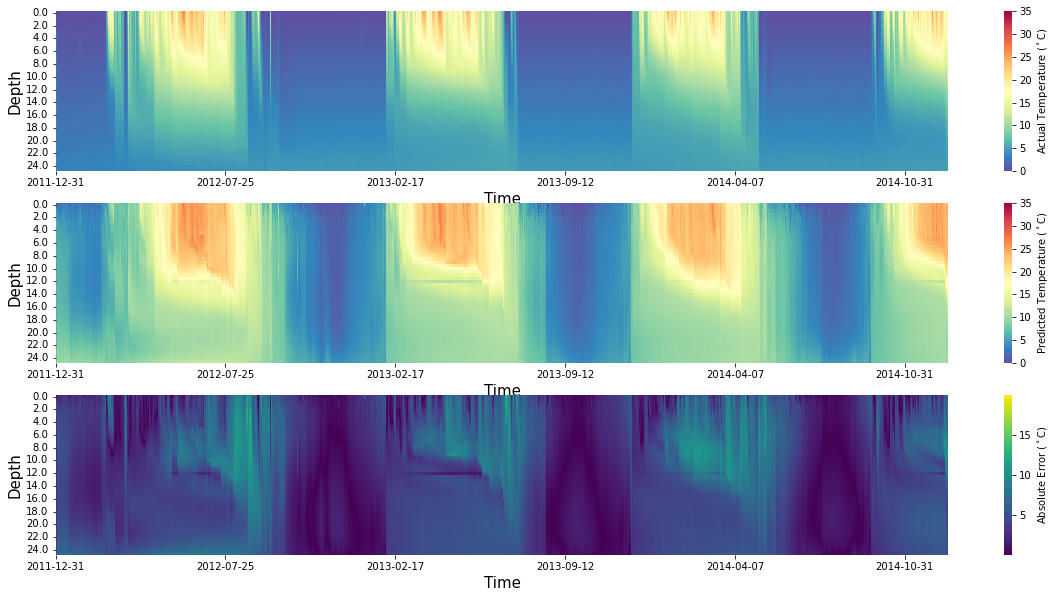

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

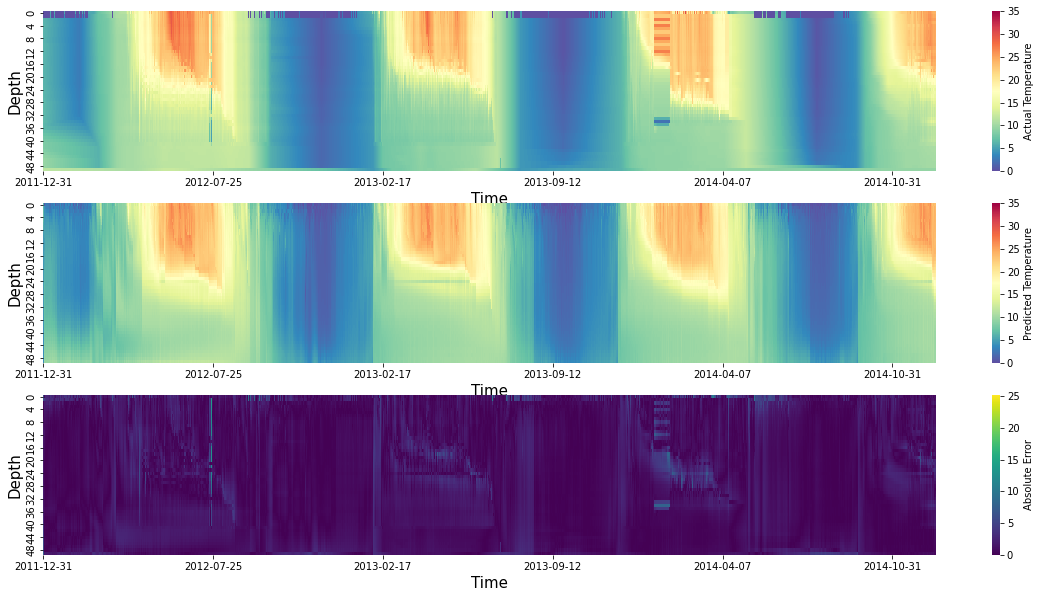

In [25]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [26]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0090550585
RMSE of after m1 0.016522184
RMSE of after m3 5.3468084
RMSE of after m4 6.745584
RMSE of after m0 0.010058648
RMSE of after m1 0.016627615
RMSE of after m3 5.4188
RMSE of after m4 6.7671056
RMSE of after m0 0.011175206
RMSE of after m1 0.018848468
RMSE of after m3 5.139082
RMSE of after m4 6.425837
RMSE of after m0 0.011941654
RMSE of after m1 0.019957943
RMSE of after m3 5.0505457
RMSE of after m4 6.331895
RMSE of after m0 0.011727795
RMSE of after m1 0.02048253
RMSE of after m3 4.993736
RMSE of after m4 6.2912283
RMSE of after m0 0.010224279
RMSE of after m1 0.019635735
RMSE of after m3 4.988462
RMSE of after m4 6.320519
RMSE of after m0 0.008626026
RMSE of after m1 0.01620574
RMSE of after m3 5.0048957
RMSE of after m4 6.2775884
RMSE of after m0 0.009490272
RMSE of after m1 0.015358796
RMSE of after m3 5.0221767
RMSE of after m4 6.2452307
RMSE of after m0 0.010674276
RMSE of after m1 0.017634274
RMSE of after m3 5.0804205
RMSE of after m4 6.345472
RMSE

RMSE of after m1 0.0066618496
RMSE of after m3 6.4323897
RMSE of after m4 6.3267655
RMSE of after m0 0.007834648
RMSE of after m1 0.0073216837
RMSE of after m3 6.4757204
RMSE of after m4 6.3558407
RMSE of after m0 0.007451316
RMSE of after m1 0.0075963656
RMSE of after m3 6.1822
RMSE of after m4 6.105569
RMSE of after m0 0.008376057
RMSE of after m1 0.007390094
RMSE of after m3 6.291275
RMSE of after m4 6.1821938
RMSE of after m0 0.008889948
RMSE of after m1 0.009967676
RMSE of after m3 7.451349
RMSE of after m4 6.9311047
RMSE of after m0 0.009549239
RMSE of after m1 0.011877009
RMSE of after m3 7.845857
RMSE of after m4 7.1705728
RMSE of after m0 0.009121007
RMSE of after m1 0.011292875
RMSE of after m3 7.5001984
RMSE of after m4 6.830749
RMSE of after m0 0.009288882
RMSE of after m1 0.009522649
RMSE of after m3 7.0133057
RMSE of after m4 6.502561
RMSE of after m0 0.007089656
RMSE of after m1 0.007921447
RMSE of after m3 6.920119
RMSE of after m4 6.5500016
RMSE of after m0 0.006907352

RMSE of after m1 0.031794883
RMSE of after m3 3.9136605
RMSE of after m4 3.501608
RMSE of after m0 0.022264007
RMSE of after m1 0.03135108
RMSE of after m3 3.8493264
RMSE of after m4 3.4281323
RMSE of after m0 0.019929828
RMSE of after m1 0.030889409
RMSE of after m3 3.8151345
RMSE of after m4 3.399677
RMSE of after m0 0.02237051
RMSE of after m1 0.03146648
RMSE of after m3 3.7229974
RMSE of after m4 3.3181179
RMSE of after m0 0.021895729
RMSE of after m1 0.032385953
RMSE of after m3 3.8577645
RMSE of after m4 3.4456446
RMSE of after m0 0.018797094
RMSE of after m1 0.030687587
RMSE of after m3 3.7755597
RMSE of after m4 3.3774474
RMSE of after m0 0.01617046
RMSE of after m1 0.026663614
RMSE of after m3 3.7452025
RMSE of after m4 3.3464875
RMSE of after m0 0.016376378
RMSE of after m1 0.027135605
RMSE of after m3 3.6715581
RMSE of after m4 3.2601712
RMSE of after m0 0.01759944
RMSE of after m1 0.027845742
RMSE of after m3 3.7895796
RMSE of after m4 3.3621347
RMSE of after m0 0.02712571


RMSE of after m0 0.02064509
RMSE of after m1 0.026483301
RMSE of after m3 1.7247167
RMSE of after m4 1.4817979
RMSE of after m0 0.020849317
RMSE of after m1 0.028349517
RMSE of after m3 1.7233686
RMSE of after m4 1.4818319
RMSE of after m0 0.016641444
RMSE of after m1 0.029548403
RMSE of after m3 2.002444
RMSE of after m4 1.7091814
RMSE of after m0 0.015140634
RMSE of after m1 0.0257595
RMSE of after m3 2.0253599
RMSE of after m4 1.7361217
RMSE of after m0 0.016703028
RMSE of after m1 0.027284956
RMSE of after m3 2.5078723
RMSE of after m4 2.0865493
RMSE of after m0 0.014595025
RMSE of after m1 0.03150072
RMSE of after m3 2.7751827
RMSE of after m4 2.2808764
RMSE of after m0 0.016377507
RMSE of after m1 0.03241862
RMSE of after m3 2.8666291
RMSE of after m4 2.3328195
RMSE of after m0 0.017186217
RMSE of after m1 0.037384342
RMSE of after m3 2.9076052
RMSE of after m4 2.3278925
RMSE of after m0 0.015751312
RMSE of after m1 0.039131418
RMSE of after m3 2.9249756
RMSE of after m4 2.354406

RMSE of after m4 4.187355
RMSE of after m0 0.008839251
RMSE of after m1 0.006782505
RMSE of after m3 4.143723
RMSE of after m4 4.156969
RMSE of after m0 0.008533647
RMSE of after m1 0.00726037
RMSE of after m3 4.0629735
RMSE of after m4 4.0978365
RMSE of after m0 0.008175011
RMSE of after m1 0.007898726
RMSE of after m3 4.1278963
RMSE of after m4 4.1901464
RMSE of after m0 0.006902739
RMSE of after m1 0.008324257
RMSE of after m3 4.0855174
RMSE of after m4 4.1756454
RMSE of after m0 0.006412415
RMSE of after m1 0.008918778
RMSE of after m3 4.086969
RMSE of after m4 4.1974688
RMSE of after m0 0.0075452384
RMSE of after m1 0.008237378
RMSE of after m3 4.0260644
RMSE of after m4 4.0687904
RMSE of after m0 0.008374142
RMSE of after m1 0.009769916
RMSE of after m3 4.1034927
RMSE of after m4 4.1699605
RMSE of after m0 0.008942844
RMSE of after m1 0.011740793
RMSE of after m3 3.979765
RMSE of after m4 4.088945
RMSE of after m0 0.009308387
RMSE of after m1 0.013799819
RMSE of after m3 3.930506

RMSE of after m3 5.0245295
RMSE of after m4 5.665809
RMSE of after m0 0.00929945
RMSE of after m1 0.017177524
RMSE of after m3 4.950478
RMSE of after m4 5.5783563
RMSE of after m0 0.010350239
RMSE of after m1 0.018072018
RMSE of after m3 4.9879355
RMSE of after m4 5.6648526
RMSE of after m0 0.011071727
RMSE of after m1 0.019111492
RMSE of after m3 4.9394164
RMSE of after m4 5.6247554
RMSE of after m0 0.010481843
RMSE of after m1 0.019892666
RMSE of after m3 4.9102035
RMSE of after m4 5.6020637
RMSE of after m0 0.011115714
RMSE of after m1 0.022002924
RMSE of after m3 4.8691053
RMSE of after m4 5.5567303
RMSE of after m0 0.010127878
RMSE of after m1 0.019893201
RMSE of after m3 4.8848696
RMSE of after m4 5.428032
RMSE of after m0 0.011186455
RMSE of after m1 0.021642176
RMSE of after m3 4.9309278
RMSE of after m4 5.5012693
RMSE of after m0 0.011689734
RMSE of after m1 0.023451125
RMSE of after m3 4.819432
RMSE of after m4 5.387715
RMSE of after m0 0.011763336
RMSE of after m1 0.02362217

RMSE of after m4 6.256461
RMSE of after m0 0.00948087
RMSE of after m1 0.014915258
RMSE of after m3 5.484746
RMSE of after m4 5.9968643
RMSE of after m0 0.0072953985
RMSE of after m1 0.011165619
RMSE of after m3 5.5964003
RMSE of after m4 6.1207633
RMSE of after m0 0.0067491387
RMSE of after m1 0.008070794
RMSE of after m3 5.995495
RMSE of after m4 6.495612
RMSE of after m0 0.008926739
RMSE of after m1 0.007972501
RMSE of after m3 6.647362
RMSE of after m4 6.890745
RMSE of after m0 0.011620303
RMSE of after m1 0.0139071485
RMSE of after m3 6.471094
RMSE of after m4 6.768432
RMSE of after m0 0.011378428
RMSE of after m1 0.017188814
RMSE of after m3 5.172481
RMSE of after m4 5.5561266
RMSE of after m0 0.010345109
RMSE of after m1 0.017225817
RMSE of after m3 5.0695796
RMSE of after m4 5.4609175
RMSE of after m0 0.011989204
RMSE of after m1 0.019706436
RMSE of after m3 4.84902
RMSE of after m4 5.248658
RMSE of after m0 0.0063624396
RMSE of after m1 0.014186555
RMSE of after m3 4.7013683
R

RMSE of after m1 0.013684201
RMSE of after m3 1.1617205
RMSE of after m4 1.1078836
RMSE of after m0 0.021066554
RMSE of after m1 0.012862014
RMSE of after m3 1.1598078
RMSE of after m4 1.1030545
RMSE of after m0 0.02178917
RMSE of after m1 0.013127852
RMSE of after m3 1.3916936
RMSE of after m4 1.3023062
RMSE of after m0 0.021093963
RMSE of after m1 0.013333948
RMSE of after m3 1.1151856
RMSE of after m4 1.0683904
RMSE of after m0 0.0206384
RMSE of after m1 0.012779764
RMSE of after m3 1.2556884
RMSE of after m4 1.1856054
RMSE of after m0 0.022563694
RMSE of after m1 0.014654778
RMSE of after m3 2.7379508
RMSE of after m4 2.4850473
RMSE of after m0 0.02163296
RMSE of after m1 0.013487407
RMSE of after m3 2.7446208
RMSE of after m4 2.4864228
RMSE of after m0 0.020923246
RMSE of after m1 0.012729214
RMSE of after m3 2.708128
RMSE of after m4 2.4560127
RMSE of after m0 0.02626862
RMSE of after m1 0.015002661
RMSE of after m3 2.8360238
RMSE of after m4 2.5625317
RMSE of after m0 0.02803705

RMSE of after m0 0.02049745
RMSE of after m1 0.0307566
RMSE of after m3 4.2028985
RMSE of after m4 3.1903956
RMSE of after m0 0.022523658
RMSE of after m1 0.015337316
RMSE of after m3 4.3629093
RMSE of after m4 3.2606864
RMSE of after m0 0.028262291
RMSE of after m1 0.009422241
RMSE of after m3 4.37609
RMSE of after m4 3.2990777
RMSE of after m0 0.037548684
RMSE of after m1 0.017640222
RMSE of after m3 4.436212
RMSE of after m4 3.3363428
RMSE of after m0 0.03279301
RMSE of after m1 0.01350242
RMSE of after m3 4.39588
RMSE of after m4 3.3162272
RMSE of after m0 0.026950294
RMSE of after m1 0.017327797
RMSE of after m3 4.3413157
RMSE of after m4 3.252615
RMSE of after m0 0.025274586
RMSE of after m1 0.00977581
RMSE of after m3 4.1898613
RMSE of after m4 3.0788293
RMSE of after m0 0.03125217
RMSE of after m1 0.014248286
RMSE of after m3 4.0976825
RMSE of after m4 3.0158145
RMSE of after m0 0.033026833
RMSE of after m1 0.013378971
RMSE of after m3 4.0767984
RMSE of after m4 3.0069673
RMSE 

RMSE of after m0 0.009596955
RMSE of after m1 0.013734802
RMSE of after m3 2.9525046
RMSE of after m4 3.0721307
RMSE of after m0 0.011346175
RMSE of after m1 0.01683613
RMSE of after m3 3.0002367
RMSE of after m4 3.031851
RMSE of after m0 0.008630639
RMSE of after m1 0.01409435
RMSE of after m3 2.9409156
RMSE of after m4 2.964044
RMSE of after m0 0.009024638
RMSE of after m1 0.012767521
RMSE of after m3 2.9558342
RMSE of after m4 2.9429
RMSE of after m0 0.011193623
RMSE of after m1 0.011500286
RMSE of after m3 2.8160064
RMSE of after m4 2.9521158
RMSE of after m0 0.0082324
RMSE of after m1 0.008066859
RMSE of after m3 3.2625513
RMSE of after m4 3.473482
RMSE of after m0 0.0073689655
RMSE of after m1 0.00899896
RMSE of after m3 3.6156082
RMSE of after m4 3.8425686
RMSE of after m0 0.006274611
RMSE of after m1 0.008217577
RMSE of after m3 3.6303046
RMSE of after m4 3.8631546
RMSE of after m0 0.008699765
RMSE of after m1 0.009044779
RMSE of after m3 3.6831958
RMSE of after m4 3.909388
RMS

RMSE of after m0 0.00934284
RMSE of after m1 0.018504813
RMSE of after m3 4.1635284
RMSE of after m4 5.1424136
RMSE of after m0 0.011019146
RMSE of after m1 0.016465606
RMSE of after m3 4.172052
RMSE of after m4 5.181106
RMSE of after m0 0.010437298
RMSE of after m1 0.016547618
RMSE of after m3 4.225881
RMSE of after m4 5.296828
RMSE of after m0 0.012126755
RMSE of after m1 0.021631673
RMSE of after m3 4.1065187
RMSE of after m4 5.1554375
RMSE of after m0 0.011641032
RMSE of after m1 0.022508979
RMSE of after m3 4.0366645
RMSE of after m4 5.0697427
RMSE of after m0 0.010549108
RMSE of after m1 0.021820998
RMSE of after m3 4.0092783
RMSE of after m4 4.9801106
RMSE of after m0 0.009815421
RMSE of after m1 0.019475477
RMSE of after m3 3.9867754
RMSE of after m4 4.8972383
RMSE of after m0 0.010579873
RMSE of after m1 0.021467257
RMSE of after m3 3.9314456
RMSE of after m4 4.8305774
RMSE of after m0 0.010995633
RMSE of after m1 0.022142226
RMSE of after m3 3.931726
RMSE of after m4 4.866987

RMSE of after m1 0.0207926
RMSE of after m3 4.927063
RMSE of after m4 6.016014
RMSE of after m0 0.008620116
RMSE of after m1 0.017208923
RMSE of after m3 4.794394
RMSE of after m4 5.880275
RMSE of after m0 0.008578784
RMSE of after m1 0.015173337
RMSE of after m3 4.8138213
RMSE of after m4 5.8576236
RMSE of after m0 0.009670195
RMSE of after m1 0.015608346
RMSE of after m3 4.937379
RMSE of after m4 5.950867
RMSE of after m0 0.011621007
RMSE of after m1 0.017828295
RMSE of after m3 4.9146113
RMSE of after m4 5.945716
RMSE of after m0 0.014198182
RMSE of after m1 0.022280727
RMSE of after m3 4.5930347
RMSE of after m4 5.5808506
RMSE of after m0 0.012624
RMSE of after m1 0.021630682
RMSE of after m3 4.541297
RMSE of after m4 5.5426693
RMSE of after m0 0.011763298
RMSE of after m1 0.021688962
RMSE of after m3 4.5426254
RMSE of after m4 5.5871453
RMSE of after m0 0.010279052
RMSE of after m1 0.019701213
RMSE of after m3 4.442749
RMSE of after m4 5.398721
RMSE of after m0 0.009757248
RMSE of

RMSE of after m3 6.6810927
RMSE of after m4 5.625836
RMSE of after m0 0.014537774
RMSE of after m1 0.016529331
RMSE of after m3 7.498324
RMSE of after m4 6.260652
RMSE of after m0 0.017098324
RMSE of after m1 0.05073102
RMSE of after m3 7.6219754
RMSE of after m4 6.3917327
RMSE of after m0 0.018138977
RMSE of after m1 0.021034833
RMSE of after m3 6.208836
RMSE of after m4 5.2790847
RMSE of after m0 0.014523519
RMSE of after m1 0.01853953
RMSE of after m3 5.9254417
RMSE of after m4 5.075859
RMSE of after m0 0.017220307
RMSE of after m1 0.01874232
RMSE of after m3 5.867473
RMSE of after m4 5.0225105
RMSE of after m0 0.019489218
RMSE of after m1 0.022382462
RMSE of after m3 5.9137907
RMSE of after m4 5.0356965
RMSE of after m0 0.018172065
RMSE of after m1 0.021128418
RMSE of after m3 5.838601
RMSE of after m4 4.9635863
RMSE of after m0 0.016827852
RMSE of after m1 0.019113297
RMSE of after m3 5.6885567
RMSE of after m4 4.8654594
RMSE of after m0 0.01310371
RMSE of after m1 0.017475897
RMS

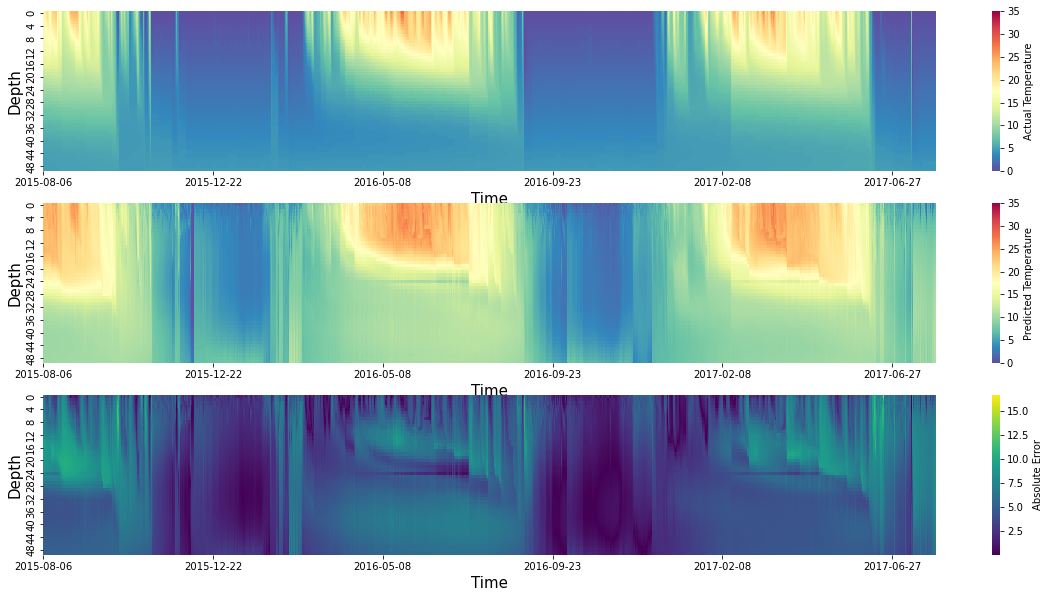

In [27]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

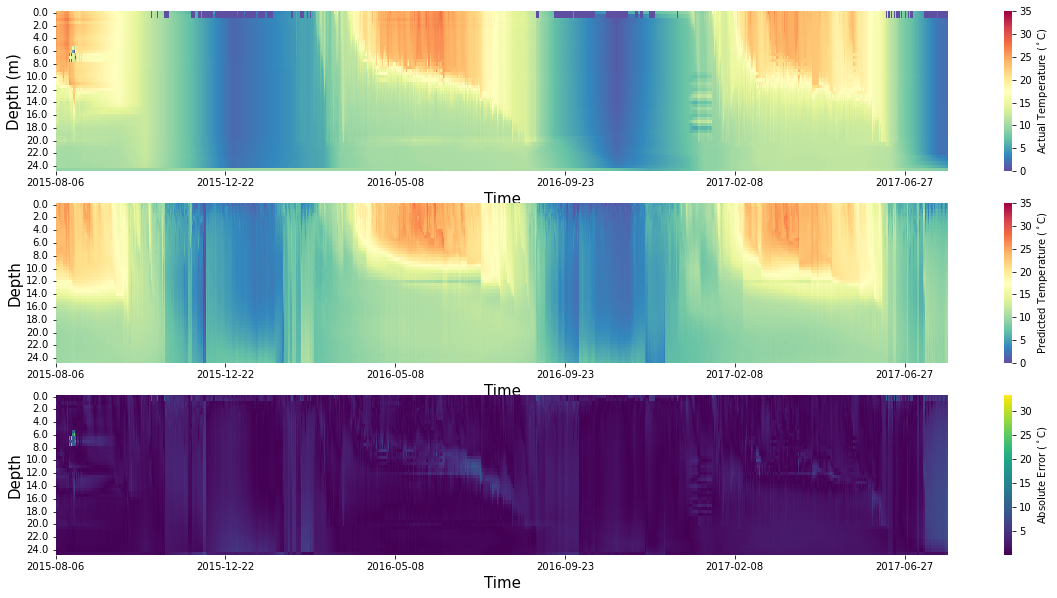

In [43]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [29]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.555871016901205, Train L2 Error: 0.5999380529779642
Test RMSE: 4.81928660966558, Train L2 Error: 0.605854504720045


## Mixing Model

## Convection Model

In [30]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.016564466585520927, Train L2 Error: 0.0021814161585095035
Test RMSE: 0.018082867571663358, Train L2 Error: 0.0022734152265340805


## Ice Model

In [31]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014016497076078948, Train L2 Error: 0.0018445259825475508
Test RMSE: 0.01633510608431941, Train L2 Error: 0.0020521246787989266


In [56]:
def plot_output_test(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)


    sns.heatmap(y_pred.T, ax=ax, cmap='Spectral_r', vmin=0., vmax=35.)
    ax.set_ylabel("Depth (m)", fontsize=15)
    ax.set_xlabel("Time", fontsize=15)
    ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax.set_xticklabels(time_label, rotation=0)
    ax.collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)")
    yticks_ix = np.array(ax.get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax.set_yticklabels(depth_label, rotation=0)

    plt.show()

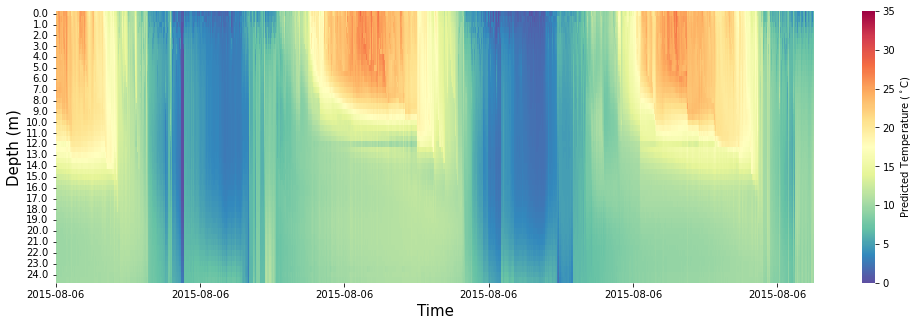

In [60]:
plot_output_test(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(17,5))

# Finetuning

# Freeze model weights